In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import enum
import random

In [16]:
E_rest = -60
E_K = -72
E_Na = 55
E_L = -49

In [192]:

#potassium
def alpha_n(V):
    if np.isclose(V, -50):
        return 0.1
    return -0.01*(V+50)/(np.exp(-0.1*(V+50))-1)

def beta_n(V):
    return 0.125*np.exp(-(V+60)/80)

def tau_n(V):
    return 1/(alpha_n(V) + beta_n(V))
              
def n_inf(V):
    return alpha_n(V) * tau_n(V)

def dn_dt(t, n, V):
    #return (n_inf(V)-n)/tau_n(V)
    return -(alpha_n(V) + beta_n(V))*n + alpha_n(V)

# sodium
def alpha_m(V):
    if np.isclose(V, -35):
        return 1.
    return -0.1*(V+35)/(np.exp(-0.1*(V+35))-1)

def beta_m(V):
    return 4*np.exp(-(V+60)/18)

def tau_m(V):
    return 1/(alpha_m(V) + beta_m(V))
              
def m_inf(V):
    return alpha_m(V) * tau_m(V)

def alpha_h(V):
    return 0.07*np.exp(-(V+60)/20)

def beta_h(V):
    return 1/(np.exp(-0.1*(V+30))+1)

def tau_h(V):
    return 1/(alpha_h(V) + beta_h(V))
              
def h_inf(V):
    return alpha_h(V) * tau_h(V)

def dm_dt(t, m, V):
    #return (n_inf(V)-n)/tau_n(V)
    return -(alpha_m(V) + beta_m(V))*m + alpha_m(V)

def dh_dt(t, h, V):
    #return (n_inf(V)-n)/tau_n(V)
    return -(alpha_h(V) + beta_h(V))*h + alpha_h(V)

def voltage_step_gating_variables(t_start, t_end, V_0, V_1, t_step):
    t = []
    n = []
    m = []
    h = []
    v = []

    sol = scipy.integrate.solve_ivp(
        lambda t, y: [dn_dt(t, y[0], V_0), dm_dt(t, y[1], V_0), dh_dt(t, y[2], V_0)],
        (t_start, t_step),
        [n_inf(V_0), m_inf(V_0), h_inf(V_0)],
        rtol=1e-12, atol=1e-12
    )
    
    t.append(sol.t)
    n.append(sol.y[0])
    m.append(sol.y[1])
    h.append(sol.y[2])
    v.append(np.full_like(sol.t, V_0))

    sol = scipy.integrate.solve_ivp(
        lambda t, y: [dn_dt(t, y[0], V_1), dm_dt(t, y[1], V_1), dh_dt(t, y[2], V_1)],
        (t_step, t_end),
        sol.y[:,-1],
        rtol=1e-12, atol=1e-12
    ) 
    
    
    t.append(sol.t)
    n.append(sol.y[0])
    m.append(sol.y[1])
    h.append(sol.y[2])
    
    return {'t': np.concatenate(t), 
            'n': np.concatenate(n), 
            'm': np.concatenate(m), 
            'h': np.concatenate(h), 
            'V': np.concatenate(v)}

    

In [167]:
# channel densities
rho_K = 60 #µm^-1
rho_Na = 300 #µm^-1

g_K = 36 #mS/cm^-2
g_Na = 120 #mS/cm^-2
g_L = 0.3 #mS/cm^-2

gamma_K = 6 #pS
gamma_Na = 4#pS

In [168]:
def P_o_K(T, V):
    return np.exp(-beta_n(V)*T)

def P_c_K(T, V):
    return np.exp(-alpha_n(V)*T)

In [199]:
class State(enum.Enum):
    OPEN = enum.auto()
    CLOSED = enum.auto()

class Gate:
    def __init__(self, gate_type, V_0, t_0):
        self._gate_type = gate_type
        
        if gate_type == 'n':
            self._alpha = alpha_n
            self._beta = beta_n
        elif gate_type == 'm':
            self._alpha = alpha_m
            self._beta = beta_m
        elif gate_type == 'h':
            self._alpha = alpha_h
            self._beta = beta_h
        else:
            raise RuntimeError('Unknown gate type')
            
        p_0 = self._alpha(V_0) / (self._alpha(V_0) + self._beta(V_0))
        r_1 = random.random()
        
        if r_1 > p_0:
            self._state = State.CLOSED
            self._T = self._step_T_c(V_0)
        else:
            self._state = State.OPEN
            self._T = self._step_T_o(V_0)
            
    def _step_T_o(self, V):
        r = random.random()
        return -1/self._beta(V)*np.log(r)
     
    def _step_T_c(self, V):
        r = random.random()
        return -1/self._alpha(V)*np.log(r)
        
            
    def voltage_step(self, t_step, V, V_new):
        while t_step > self._T:     
            if (self._state == State.CLOSED):
                self._state = State.OPEN
                self._T += self._step_T_o(V)
            else:
                self._state = State.CLOSED
                self._T += self._step_T_c(V)
                
        # note: closed and open changed compared to while loop.
        if (self._state == State.CLOSED):
                self._state = State.OPEN
                self._T = t_step + self._step_T_o(V_new)
        else:
            self._state = State.CLOSED
            self._T = t_step + self._step_T_c(V_new)
                
    def is_open(self, t, V):
        last_state = self._state
        while t > self._T:
            last_state = self._state
            if (self._state == State.CLOSED):
                self._state = State.OPEN
                self._T += self._step_T_o(V)
            else:
                self._state = State.CLOSED
                self._T += self._step_T_c(V)
                
        return last_state == State.OPEN
    
class Channel:
    def __init__(self, channel_type, V_0, t_0):
        self._channel_type = channel_type
        if channel_type == 'K':
            self._gates = [Gate('n', V_0, t_0) for _ in range(4)]
        elif channel_type == 'Na':
            self._gates = [Gate('m', V_0, t_0) for _ in range(3)]    
            self._gates.append(Gate('h', V_0, t_0))
        else:
            raise RuntimeError('Unknown channel type')
            
        
    def voltage_step(self, t_step, V, V_new):
        for gate in self._gates:
            gate.voltage_step(t_step, V, V_new)
            
    def is_open(self, t, V):
        if self._channel_type == 'K':
            return np.sum([gate.is_open(t, V) for gate in self._gates]) == 4
        else:
            return (np.sum([gate.is_open(t, V) for gate in self._gates[0:3]]) == 3 and
                    self._gates[3].is_open(t, V))

    
            
def frac_open_channel(channels, *args):
    return np.sum([channel.is_open(*args) for channel in channels]) / len(channels)

def voltage_step_channels(channels, *args):
    for channel in channels:
        channel.voltage_step(*args)
        

def simulate_channels(channel_type, n_channels, V1, V2):
    dt = 0.05
    T = np.arange(0, 60, dt)

    channels = [Channel(channel_type, V1, 0.) for _ in range(n_channels)]

    x_stoch = [frac_open_channel(channels, 0., V1)]

    for t in T[T<30]:
        x_stoch.append(frac_open_channel(channels, t, V1))

    voltage_step_channels(channels, 30, V1, V2)

    for t in T[T>=30]:
        x_stoch.append(frac_open_channel(channels, t, V2))


    return T, np.array(x_stoch)

In [204]:
T_Na, n_Na_stoch = simulate_channels('Na', 500, -50, -10)
T_K, n_K_stoch = simulate_channels('K', 500, -50, -10)

In [205]:
sol_HH = voltage_step_gating_variables(0, 80, -50, -10, 30)

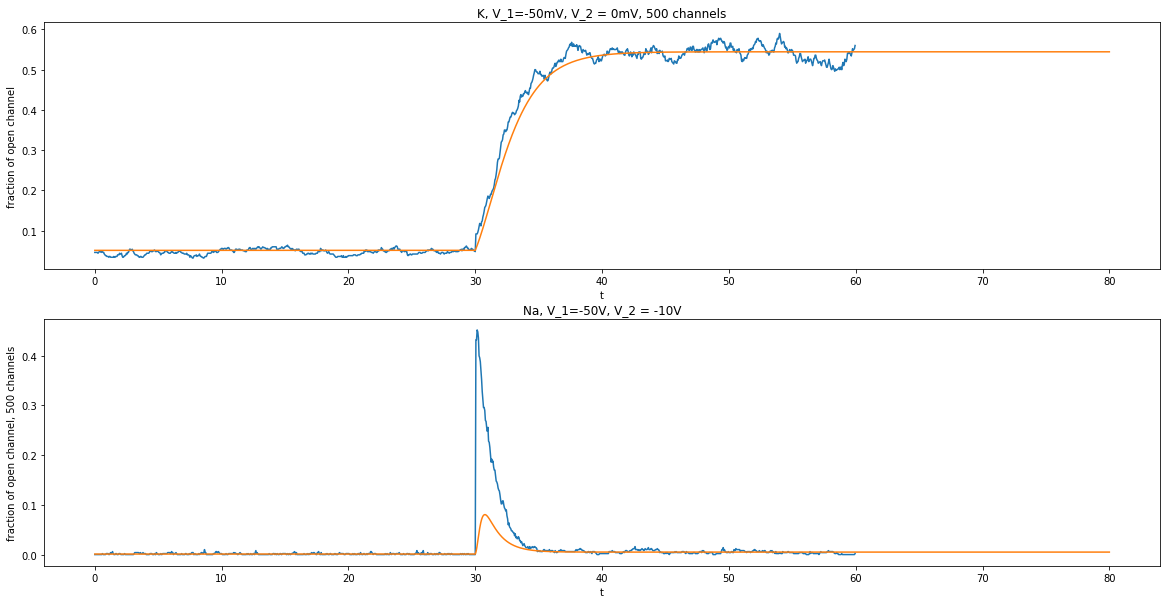

In [208]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 10))

axs[0].plot(T_K, n_K_stoch[:-1], label='stoch')
axs[0].plot(sol_HH['t'], sol_HH['n']**4, label='Hodgkin Huxley')
axs[0].set_xlabel('t')
axs[0].set_ylabel('fraction of open channel')
axs[0].set_title('K, V_1=-50mV, V_2 = 0mV, 500 channels')

axs[1].plot(T_K, n_Na_stoch[:-1], label='stoch')
axs[1].plot(sol_HH['t'], sol_HH['h']*sol_HH['m']**3, label='Hodgkin Huxley')
axs[1].set_xlabel('t')
axs[1].set_ylabel('fraction of open channel, 500 channels')
axs[1].set_title('Na, V_1=-50V, V_2 = -10V')

plt.show()